## The Goal of this notebook is to build a simple Unet baseline model using Keras 

U-Net: Convolutional Networks for Biomedical Image Segmentation - https://arxiv.org/pdf/1505.04597.pdf

Inspired from https://github.com/jocicmarko/ultrasound-nerve-segmentation

In [0]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.measure import label, regionprops
from PIL import Image, ImageDraw
from ast import literal_eval
from tqdm.notebook import tqdm

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
assert IMG_WIDTH == IMG_HEIGHT

IMG_CHANNELS = 3
TRAIN_PATH = '/content/gdrive/My Drive/Object Detection/train'
TEST_PATH = '/content/gdrive/My Drive/Object Detection/test'
SC_FACTOR = int(1024 / IMG_WIDTH)

warnings.filterwarnings('ignore')
seed = 42
random.seed = seed
np.random.seed = seed

In [0]:
PATH = "/content/gdrive/My Drive/Object Detection/"
train_folder = os.path.join(PATH, "train")
test_folder = os.path.join(PATH, "test")

train_csv_path = os.path.join(PATH, "train.csv")
df = pd.read_csv(train_csv_path)
sample_sub = pd.read_csv(PATH + "sample_submission.csv")

df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [0]:
# Get train and test IDs and paths
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

### Convert multiple bounding boxes to masks

In [0]:
def make_polygon(coords):
  xm, ym, w, h = coords
  xm, ym, w, h = xm / SC_FACTOR, ym / SC_FACTOR, w / SC_FACTOR, h / SC_FACTOR   # scale values if image was downsized
  return [(xm, ym), (xm, ym + h), (xm + w, ym + h), (xm + w, ym)]

masks = dict() # dictionnary containing all masks

for img_id, gp in tqdm(df.groupby("image_id")):
  gp['polygons'] = gp['bbox'].apply(eval).apply(lambda x: make_polygon(x))

  img = Image.new('L', (IMG_WIDTH, IMG_HEIGHT), 0)
  for pol in gp['polygons'].values:
      ImageDraw.Draw(img).polygon(pol, outline=1, fill=1)

  mask = np.array(img, dtype=np.uint8)
  masks[img_id] = mask

### Let's plot a quick example of the mask of the first image : 

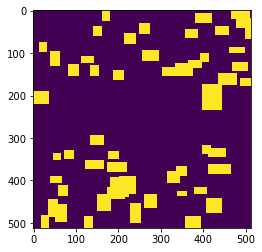

In [0]:
im = Image.fromarray(masks[list(masks.keys())[7]])
plt.imshow(im)

### Let's load the dataset

In [0]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids[:]), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    id_clean = id_.split('.')[0]
    if id_clean in masks.keys():
        Y_train[n] = masks[id_clean][:, :, np.newaxis]
        

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = list()
print('Getting and resizing test images... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks... 



Getting and resizing test images... 



Done!


In [0]:
X_train.shape, Y_train.shape

((3422, 512, 512, 3), (3422, 512, 512, 1))

Let's quickly look at what the images and mask look like (credits : https://www.kaggle.com/devvindan/wheat-detection-eda)

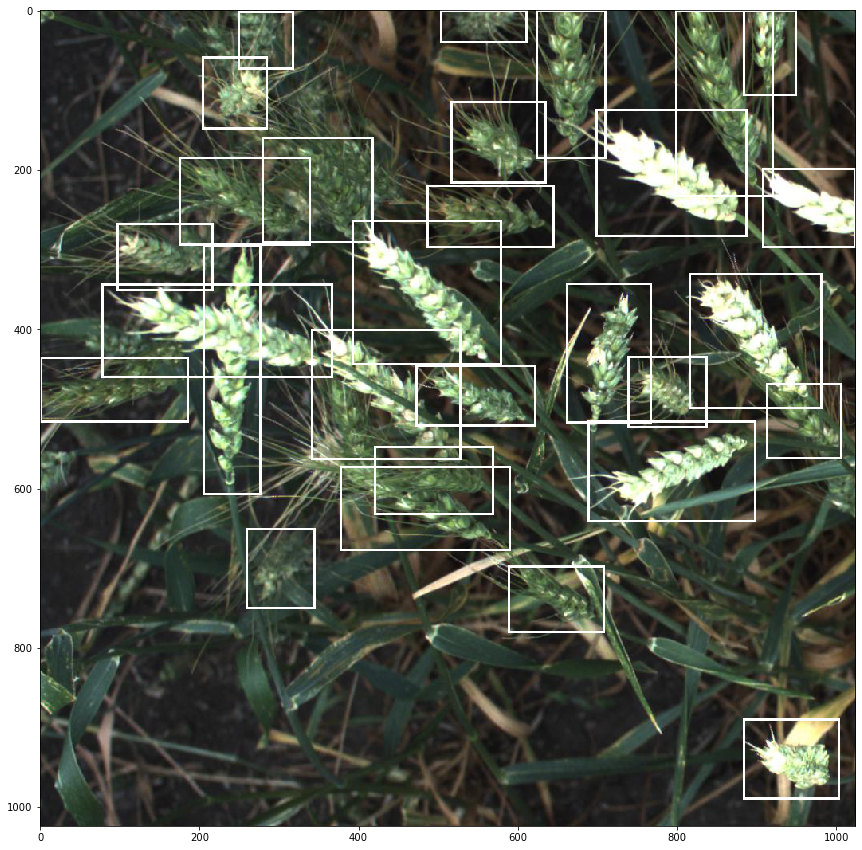

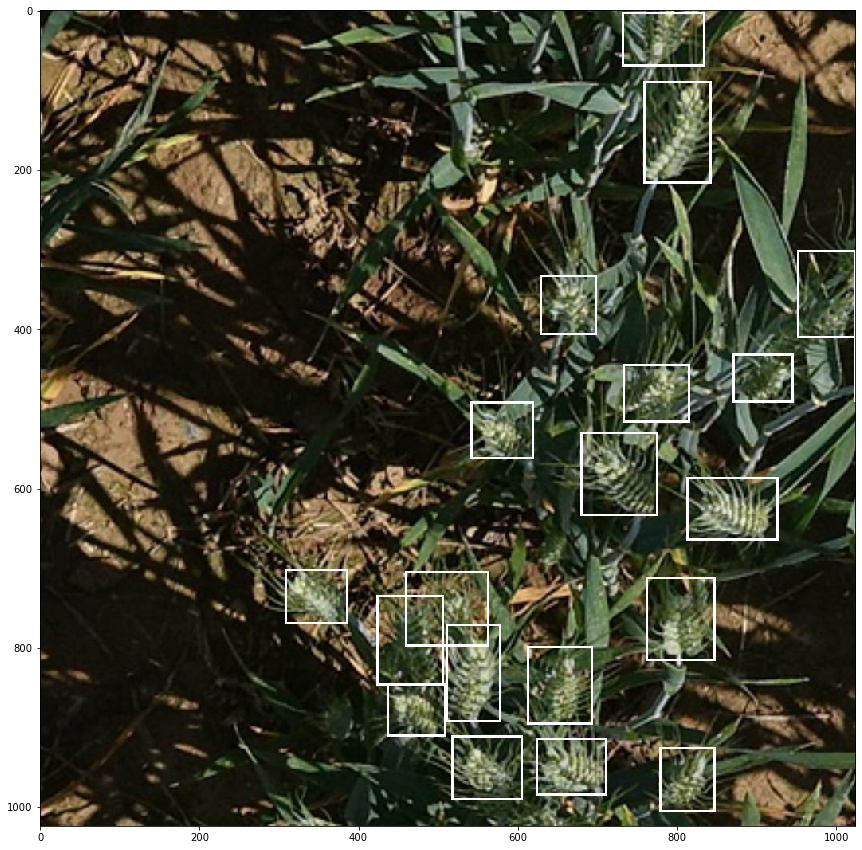

In [0]:
def show_images(images, num=2):
    
    images_to_show = np.random.choice(images, num)

    for image_id in images_to_show:

        image_path = os.path.join(train_folder, image_id + ".jpg")
        image = Image.open(image_path)

        # get all bboxes for given image in [xmin, ymin, width, height]
        bboxes = [literal_eval(box) for box in df[df['image_id'] == image_id]['bbox']]

        # visualize them
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:    
            draw.rectangle([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], width=3)

        plt.figure(figsize = (15,15))
        plt.imshow(image)
        plt.show()


unique_images = df['image_id'].unique()
show_images(unique_images)

In [0]:
#Credits to : https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63044

def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred): #any shape can go - can't be a loss function

    tresholds = [0.5 + (i * 0.05)  for i in range(5)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [0]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[competitionMetric2])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512, 512, 16) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

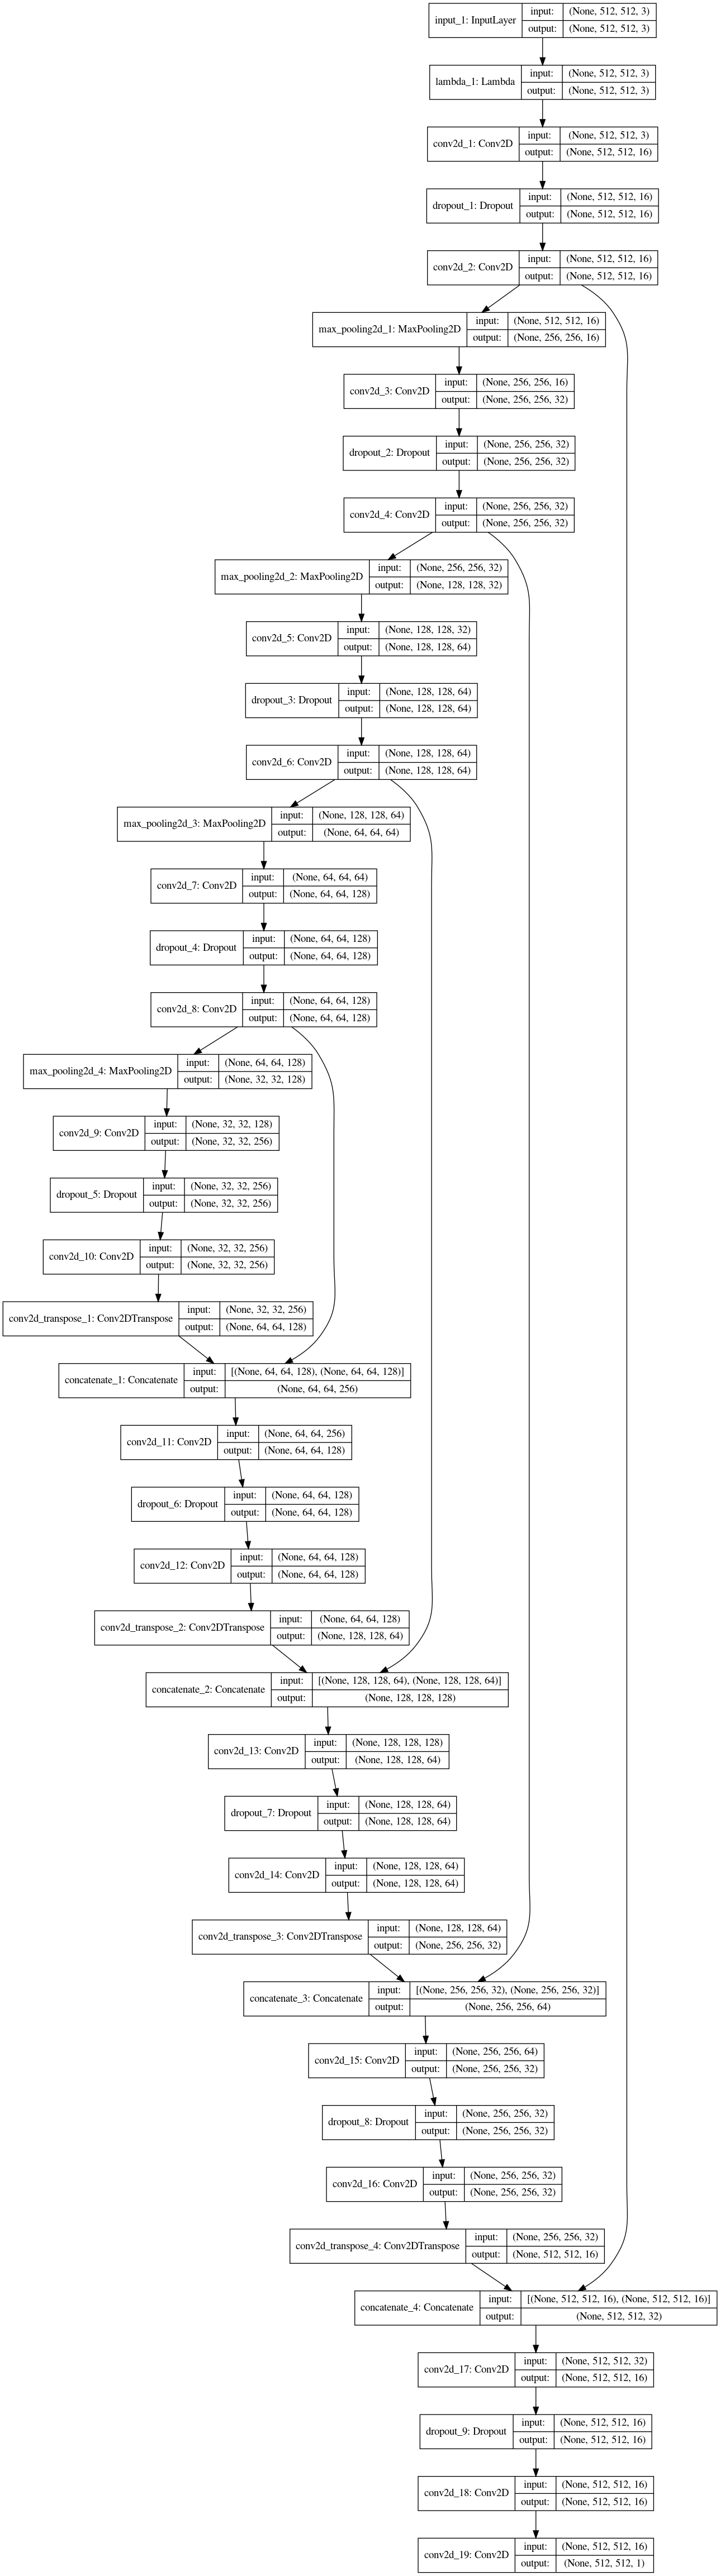

In [0]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [0]:
# Fit model
earlystop = EarlyStopping(patience=15, verbose=1)

hist = model.fit(X_train, 
                 Y_train,
                 validation_split=0.2,
                 batch_size=16, 
                 epochs=40, 
                 callbacks=[earlystop],
                )

Train on 2737 samples, validate on 685 samples
Epoch 1/40
2737/2737 [==============================] - 84s 31ms/step - loss: 0.4725 - competitionMetric2: 0.0634 - val_loss: 0.4082 - val_competitionMetric2: 0.1935
Epoch 2/40
2737/2737 [==============================] - 76s 28ms/step - loss: 0.3685 - competitionMetric2: 0.2632 - val_loss: 0.3516 - val_competitionMetric2: 0.3749
Epoch 3/40
2737/2737 [==============================] - 76s 28ms/step - loss: 0.3042 - competitionMetric2: 0.4903 - val_loss: 0.4638 - val_competitionMetric2: 0.2634
Epoch 4/40
2737/2737 [==============================] - 76s 28ms/step - loss: 0.2607 - competitionMetric2: 0.6307 - val_loss: 0.4377 - val_competitionMetric2: 0.2421
Epoch 5/40
2737/2737 [==============================] - 76s 28ms/step - loss: 0.2342 - competitionMetric2: 0.7138 - val_loss: 0.2407 - val_competitionMetric2: 0.7577
Epoch 6/40
2737/2737 [==============================] - 76s 28ms/step - loss: 0.2154 - competitionMetric2: 0.7846 - val_los

## Prediction

As `X_test` is already formatted, we can directly make a prediction

In [0]:
THRESH = 0.7

preds = model.predict(X_test)[:, :, :, 0]
masked_preds = preds > THRESH

Here we want to binarize the prediction to get a mask (as the input y_train was also a mask)

* Let's visualise predictions ! 

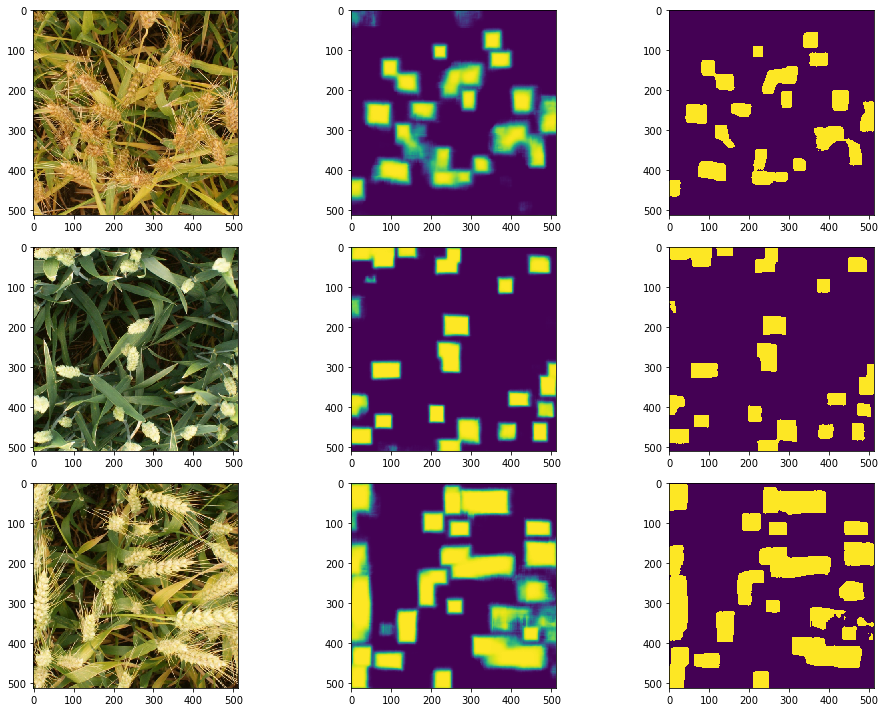

In [0]:
n_rows = 3

f, ax = plt.subplots(n_rows, 3, figsize=(14, 10))

for j, idx in enumerate([4,5,6]):
    for k, kind in enumerate(['original', 'pred', 'masked_pred']):
        if kind == 'original':
            img = X_test[idx]
        elif kind == 'pred':
            img = preds[idx]
        elif kind == 'masked_pred':
            masked_pred = preds[idx] > .75
            img = masked_pred
        ax[j, k].imshow(img)

plt.tight_layout()

Seems not too bad ! 

### Now the next step is to translate our masked predictions into several bouding boxes

For the moment, I'll assign 1.0 confidence for every box

In [0]:
def get_params_from_bbox(coords, scaling_factor=1):
    xmin, ymin = coords[1] * scaling_factor, coords[0] * scaling_factor
    w = (coords[3] - coords[1]) * scaling_factor
    h = (coords[2] - coords[0]) * scaling_factor
    
    return xmin, ymin, w, h

In [0]:
# Allows to extract bounding boxes from binary masks
bboxes = list()

for j in range(masked_preds.shape[0]):
    label_j = label(masked_preds[j, :, :]) 
    props = regionprops(label_j)
    bboxes.append(props)

In [0]:
output = dict()
for i in range(masked_preds.shape[0]):
    bboxes_processed = [get_params_from_bbox(bb.bbox, scaling_factor=SC_FACTOR) for bb in bboxes[i]]
    formated_boxes = ['1.0 ' + ' '.join(map(str, bb_m)) for bb_m in bboxes_processed]
    #if formated_boxes:
    #    formated_boxes = formated_boxes[0] 
    
    output[sample_sub["image_id"][i]] = " ".join(formated_boxes)
    #output[sample_sub["image_id"][i]] = formated_boxes

In [0]:
sample_sub["PredictionString"] = output.values()

In [0]:
sample_sub

image_id                                   PredictionString
0  aac893a91  1.0 382 2 76 92 1.0 766 6 92 118 1.0 960 8 64 ...
1  51f1be19e  1.0 382 14 32 22 1.0 644 50 132 98 1.0 48 104 ...
2  f5a1f0358  1.0 16 46 226 138 1.0 310 74 80 110 1.0 618 10...
3  796707dd7  1.0 26 0 80 64 1.0 816 84 110 76 1.0 606 88 15...
4  51b3e36ab  1.0 668 108 78 84 1.0 416 180 58 58 1.0 700 21...
5  348a992bb  1.0 2 0 214 106 1.0 236 0 88 54 1.0 426 10 120...
6  cc3532ff6  1.0 0 2 98 144 1.0 468 18 318 144 1.0 364 150 ...
7  2fd875eaa  1.0 540 36 70 86 1.0 140 38 112 82 1.0 660 50 ...
8  cb8d261a3  1.0 600 44 60 70 1.0 442 126 88 60 1.0 808 174...
9  53f253011  1.0 320 0 56 60 1.0 262 90 118 136 1.0 96 106 ...

In [0]:
sample_sub.to_csv('submission.csv', index=False)